# **Stats of the Country Music Network**

### **Construction of the Country Music Network**

In the following sections we will briefly show how we constructed the Country Music Network prior to conducting summary statistics upon it.

We were uncertain whether this was part of the task so I chose include it in a separate section. You can simply collapse the section if that isn't the case.

#### Fetching all the wiki pages of the country musicians

We extract all the musicians by clicking edit on the following wikipedia page [List of Country Musicians](https://en.wikipedia.org/wiki/List_of_country_music_performers) and saving the contents as a txt file

In [1]:
import re

# Path to the country musician text file
path = r"data\week4_country_music.txt"

# Regular expression pattern that match all Wikipedia page names in double brackets that are not files or categories
pattern = re.compile(r'\[\[(?!File:|Category:)([^|\]]+)')

# List to store Wikipedia page names
page_names = []

# Open and read the text file
with open(path, 'r', encoding='utf-8') as file:
    for line in file:
        matches = pattern.findall(line)
        for match in matches:
            # Replace spaces with underscores
            page_name = match.strip().replace(' ', '_')
            page_names.append(page_name)

print(f"Found {len(page_names)} Wikipedia page names.")

Found 2155 Wikipedia page names.


#### Fetching links, content length and building the Country Music Graph

For each musician in the list:
- We extract all the links in the text of the wikipedia page
- Calculate the content length
- Add a node to the graph with the musician and the content length as a node attribute
- Add an edge for each link found (if the link points to a musician in the list of country musician)

We use asyncio and aiohttp to speed up the process of pulling the pages.

In [ ]:
import asyncio
import aiohttp
import json
import networkx as nx
from tqdm.notebook import tqdm
import re

# Convert the list to a set for faster lookup
page_names_set = set(page_names)

# Initialize a directed graph
G = nx.DiGraph()

# Base URL for the Wikipedia API
baseurl = "https://en.wikipedia.org/w/api.php"

# User-Agent header
headers = {
    'User-Agent': 'MyWikipediaApp/1.0 (https://example.com; myemail@example.com)'
}

# Semaphore to limit the number of concurrent requests
semaphore = asyncio.Semaphore(5) 

def extract_wikitext_links(wikitext):
    """
    Extract links from the raw wikitext of a Wikipedia page using regex.
    This function looks for `[[link]]` style links and converts them into usable format.
    """
    # Use regex to extract double-bracketed links like [[link]]
    raw_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]', wikitext)
    
    # Extract just the first part before the pipe (if there's a pipe, we only care about the actual link part)
    # We filter out special links like 'Category:', 'File:', etc.
    cleaned_links = [link[0].replace(' ', '_') for link in raw_links if ':' not in link[0]]

    return cleaned_links

def calculate_word_count(wikitext):
    """
    Calculate the word count based on the wikitext content.
    """
    # Split the wikitext into words
    words = wikitext.split()
    return len(words)

async def fetch_wikitext_and_links(session, title):
    links = set()
    content_length = 0
    continue_param = None

    # Fetch the wikitext instead of the extract and links
    while True:
        async with semaphore:
            # Base parameters for the API request
            params = {
                'action': 'query',
                'titles': title,
                'format': 'json',
                'prop': 'revisions',
                'rvprop': 'content',
                'redirects': '1',
            }

            if continue_param:
                params['rvcontinue'] = continue_param

            try:
                async with session.get(baseurl, headers=headers, params=params) as response:
                    response.raise_for_status()
                    page_content = await response.json()

                    # Process redirects if any
                    if 'redirects' in page_content.get('query', {}):
                        for redir in page_content['query']['redirects']:
                            title = redir['to'].replace(' ', '_')

                    # Get the page ID (key in the 'pages' dictionary)
                    page_id = next(iter(page_content['query']['pages']))
                    page_data = page_content['query']['pages'][page_id]

                    # Get the wikitext from the revisions content
                    if 'revisions' in page_data:
                        wikitext = page_data['revisions'][0]['*']

                        # Extract links from the wikitext
                        wikitext_links = extract_wikitext_links(wikitext)

                        # Calculate word count (length of content)
                        content_length = calculate_word_count(wikitext)

                        # Filter the links to only include other performers in page_names_set
                        for link in wikitext_links:
                            if link in page_names_set:
                                links.add(link)
                    break
            except Exception as e:
                print(f"An error occurred while fetching links for {title}: {e}")
                break

    return title, links, content_length

async def main(page_names):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for title in page_names:
            task = asyncio.create_task(fetch_wikitext_and_links(session, title))
            tasks.append(task)

        results = []
        for f in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc='Processing pages'):
            result = await f
            results.append(result)

        # Build the graph
        for title, links, content_length in results:
            # Add the node with the length of content as an attribute
            G.add_node(title, length_of_content=content_length)
            # Add the edges (links to other coutry mucisians)
            for link in links:
                G.add_edge(title, link)

# Run the main coroutine
await main(page_names)



In [16]:
# find nodes where "length_of_content" does not exist
nodes_missing_content = [node for node, data in G.nodes(data=True) if 'length_of_content' not in data]
print(f"Nodes missing content length: {len(nodes_missing_content)}")


# set the missing content length to 0
# These are edge cases that we don't deem important enough to investigate further
for node in nodes_missing_content:
    G.nodes[node]['length_of_content'] = 0
nx.write_graphml(G, "data/graph.graphml")

Nodes missing content length: 57


## **Simple network statistics and analysis**

In [2]:
import networkx as nx
# load the graph
G = nx.read_graphml("data/graph.graphml")

#### **What is the number of nodes and links (edges) in the network?**

In [18]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 2152
Number of edges: 18214


As seen in the print output above we have constructed a network of 2152 nodes and 18124 edges. That is, we have 2152 Country Musicians who's wikipedia pages are interconnected with 18124 links.

#### **Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?**

The degree distributions are essential to understand the structure of the network. We will plot both the in-degree and out-degree distributions.

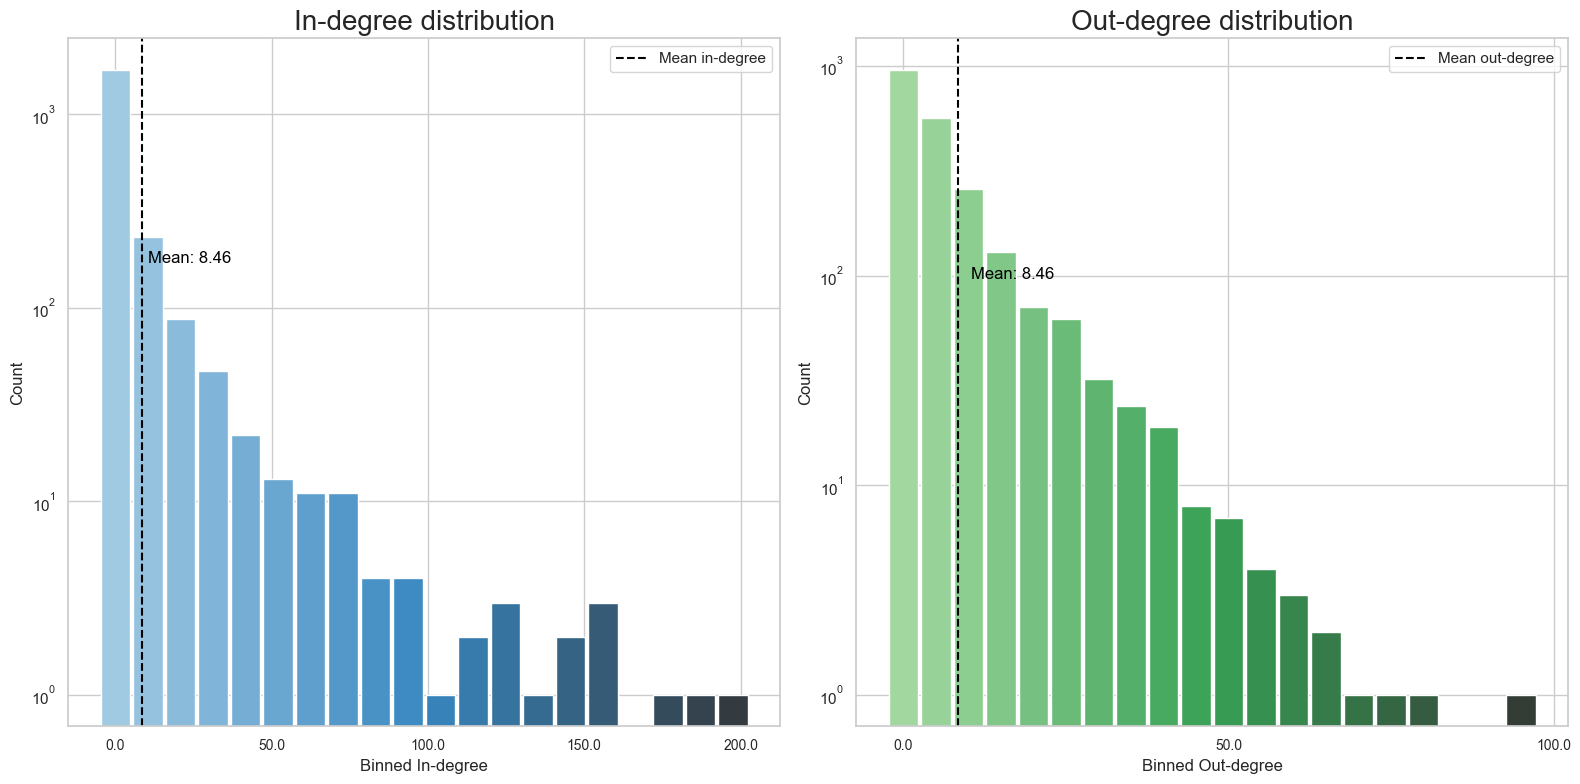

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# remove future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set a Seaborn theme for aesthetics
sns.set(style="whitegrid")

# Compute the in-degree and out-degree distributions
in_degrees = list(dict(G.in_degree()).values())
out_degrees = list(dict(G.out_degree()).values())

# Define the number of bins
num_bins = 20  # Decrease number of bins to make bars larger

# Binning the in-degree and out-degree values
in_hist, in_bins = np.histogram(in_degrees, bins=num_bins)
out_hist, out_bins = np.histogram(out_degrees, bins=num_bins)

# Create the plot for in-degree and out-degree distributions
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Larger figure size for bigger bars

# Use plt.bar to control the width of bins
bar_width = (in_bins[1] - in_bins[0]) * 0.9  # Make bar width slightly smaller than bin width

# Plot the binned in-degree distribution using plt.bar
ax[0].bar(in_bins[:-1], in_hist, width=bar_width, color=sns.color_palette("Blues_d", num_bins))
ax[0].set_title("In-degree distribution")
ax[0].title.set_fontsize(20)
ax[0].set_xlabel("Binned In-degree")
ax[0].set_ylabel("Count")
# Set x-ticks at intervals of 50
ax[0].set_xticks(np.arange(0, max(in_bins) + 1, 50))
# Manually format x-tick labels to be more readable
ax[0].set_xticklabels(np.arange(0, max(in_bins) + 1, 50), fontsize=10)
# Calculate mean in-degree and plot the vertical line
mean_in_degree = np.mean(in_degrees)
ax[0].axvline(x=mean_in_degree, color='black', linestyle='--', label='Mean in-degree')
# Add text showing the mean in-degree value
ax[0].text(mean_in_degree + 2, max(in_hist) / 10, f'Mean: {mean_in_degree:.2f}', color='black', fontsize=12)
ax[0].set_yscale('log')
ax[0].legend()

# Plot the binned out-degree distribution using plt.bar
bar_width = (out_bins[1] - out_bins[0]) * 0.9  # Same adjustment for out-degree
ax[1].bar(out_bins[:-1], out_hist, width=bar_width, color=sns.color_palette("Greens_d", num_bins))
ax[1].set_title("Out-degree distribution")
ax[1].title.set_fontsize(20)
ax[1].set_xlabel("Binned Out-degree")
ax[1].set_ylabel("Count")
# Set x-ticks at intervals of 50
ax[1].set_xticks(np.arange(0, max(out_bins) + 1, 50))
# Manually format x-tick labels to be more readable
ax[1].set_xticklabels(np.arange(0, max(out_bins) + 1, 50), fontsize=10)
# Calculate mean out-degree and plot the vertical line
mean_out_degree = np.mean(out_degrees)
ax[1].axvline(x=mean_out_degree, color='black', linestyle='--', label='Mean out-degree')
# Add text showing the mean out-degree value
ax[1].text(mean_out_degree + 2, max(out_hist) / 10, f'Mean: {mean_out_degree:.2f}', color='black', fontsize=12)
ax[1].set_yscale('log')
ax[1].legend()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


From the plot above we see the in-degree distribution is left skewed because certain performers are frequently referenced, while the out-degree distribution is more uniform. Typically, the in-degree distribution is more skewed in real-world networks like Wikipedia than the out-degree distribution. This is because a few prominent musicians (e.g., historically significant figures) tend to have a lot of incoming links (in-degree) as they are referenced frequently by others. On the other hand, out-degree represents how often a musician's page links to others, which may vary less because pages tend to have more standardized structures or patterns for linking. This is analogous to the concept of your friends often having more friends than you which we have encounted during class in this course.

#### **Compare the out-degree distribution to a *random network* with the same number of nodes and links?**

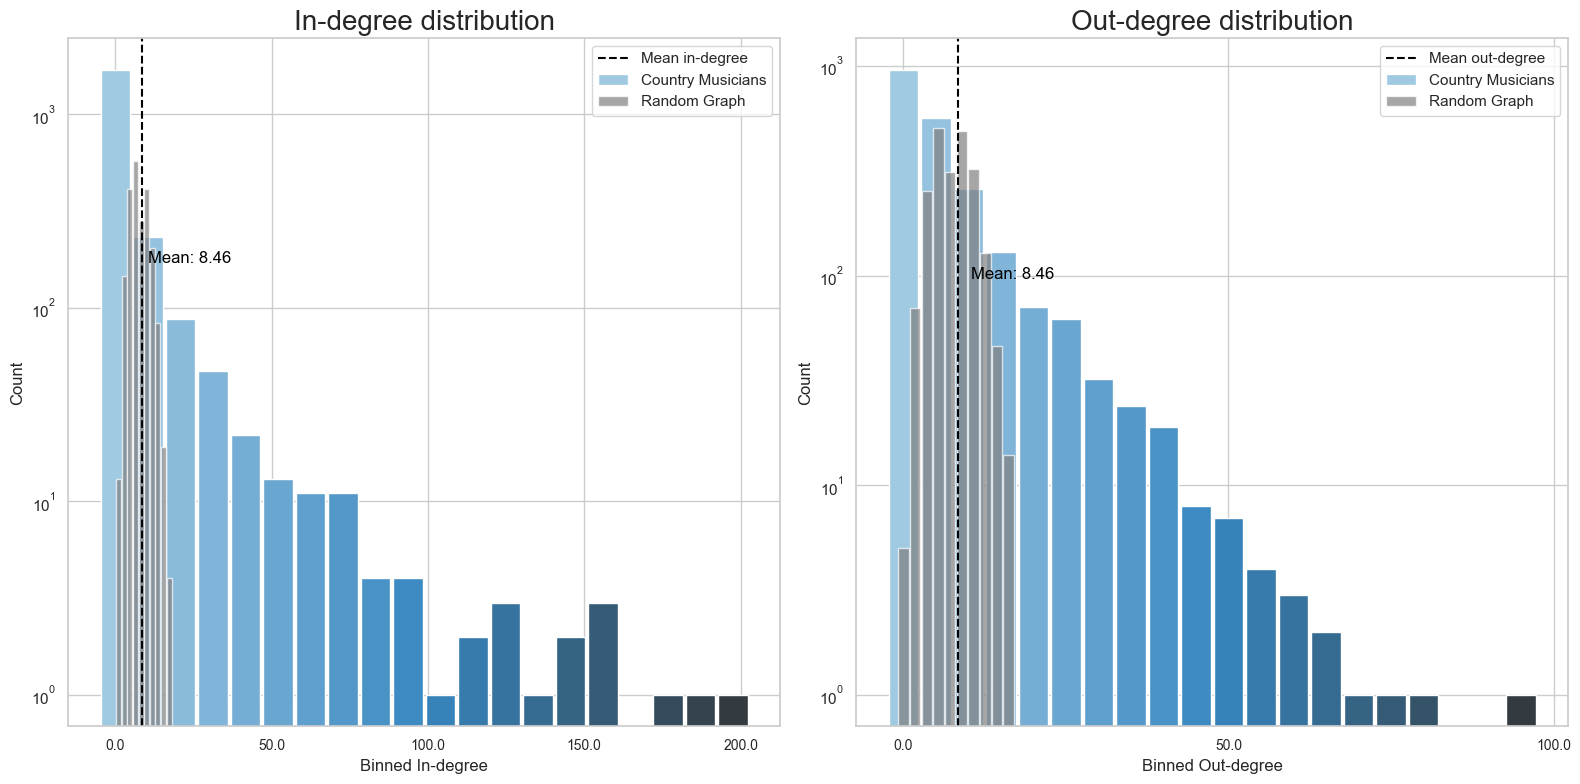

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

# Set a Seaborn theme for aesthetics
sns.set(style="whitegrid")

# Parameters for the graph
number_nodes = 2152
number_edges = 18213

# Calculate the linking probability
linking_probability = number_edges / (number_nodes * (number_nodes - 1))
# print(f"The linking probability is {linking_probability:.10f}")

# Create a Random Graph
random_graph = nx.erdos_renyi_graph(number_nodes, linking_probability, directed=True)

# Get in-degree and out-degree distributions for the random graph
random_in_degrees = list(dict(random_graph.in_degree()).values())
random_out_degrees = list(dict(random_graph.out_degree()).values())

# Compute the binned histograms for in-degree and out-degree distributions
num_bins_country = 20  # Number of bins for Country Musicians
num_bins_random = 10  # Fewer bins for the random graph for clarity

# Histograms for Country Musicians Graph
in_hist, in_bins = np.histogram(in_degrees, bins=num_bins_country)
out_hist, out_bins = np.histogram(out_degrees, bins=num_bins_country)

# Histograms for Random Graph (with fewer bins)
random_in_hist, random_in_bins = np.histogram(random_in_degrees, bins=num_bins_random)
random_out_hist, random_out_bins = np.histogram(random_out_degrees, bins=num_bins_random)

# Create the plot for in-degree and out-degree distributions
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Large figure size

# Use plt.bar to control the width of bins
bar_width_country = (in_bins[1] - in_bins[0]) * 0.9  # Adjust bar width for Country Musicians
bar_width_random = (random_in_bins[1] - random_in_bins[0]) * 0.9  # Adjust bar width for Random Graph

# Plot the binned in-degree distribution
ax[0].bar(in_bins[:-1], in_hist, width=bar_width_country, color=sns.color_palette("Blues_d", num_bins_country), label="Country Musicians")
ax[0].bar(random_in_bins[:-1], random_in_hist, width=bar_width_random, alpha=0.7, color="gray", label="Random Graph")
ax[0].set_title("In-degree distribution")
ax[0].title.set_fontsize(20)
ax[0].set_xlabel("Binned In-degree")
ax[0].set_ylabel("Count")
ax[0].set_xticks(np.arange(0, max(in_bins) + 1, 50))
ax[0].set_xticklabels(np.arange(0, max(in_bins) + 1, 50), fontsize=10)
mean_in_degree = np.mean(in_degrees)
ax[0].axvline(x=mean_in_degree, color='black', linestyle='--', label='Mean in-degree')
ax[0].text(mean_in_degree + 2, max(in_hist) / 10, f'Mean: {mean_in_degree:.2f}', color='black', fontsize=12)
ax[0].set_yscale('log')
ax[0].legend()

# Plot the binned out-degree distribution
bar_width_country = (out_bins[1] - out_bins[0]) * 0.9  # Adjust bar width for Country Musicians
bar_width_random = (random_out_bins[1] - random_out_bins[0]) * 0.9  # Adjust bar width for Random Graph

ax[1].bar(out_bins[:-1], out_hist, width=bar_width_country, color=sns.color_palette("Blues_d", num_bins_country), label="Country Musicians")
ax[1].bar(random_out_bins[:-1], random_out_hist, width=bar_width_random, alpha=0.7, color="gray", label="Random Graph")
ax[1].set_title("Out-degree distribution")
ax[1].title.set_fontsize(20)
ax[1].set_xlabel("Binned Out-degree")
ax[1].set_ylabel("Count")
ax[1].set_xticks(np.arange(0, max(out_bins) + 1, 50))
ax[1].set_xticklabels(np.arange(0, max(out_bins) + 1, 50), fontsize=10)
mean_out_degree = np.mean(out_degrees)
ax[1].axvline(x=mean_out_degree, color='black', linestyle='--', label='Mean out-degree')
ax[1].text(mean_out_degree + 2, max(out_hist) / 10, f'Mean: {mean_out_degree:.2f}', color='black', fontsize=12)
ax[1].set_yscale('log')
ax[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In a random network, edges are assigned between nodes uniformly at random, resulting in a more bell-curve-like distribution. In contrast, real-world networks (like Wikipedia links) are often not random, because pages are structured and follow patterns of influence and relevance. This phenomena is exactly what we see in the two plots above. We note that the scale of the x-axis is twice as large in the left plot compared to the right which makes variance of the Random Graph distribution look different.

#### **Compare the in-degree distribution to a scale-free network with the same number of nodes**

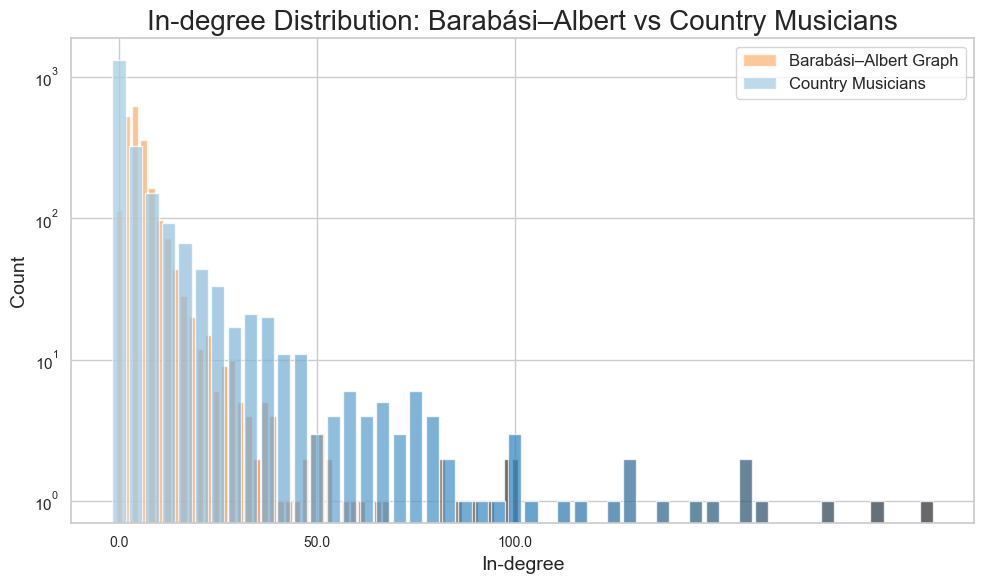

In [53]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a Seaborn theme for aesthetics
sns.set(style="whitegrid")

# Parameters for the graph
number_nodes = 2152
number_edges = 18213

# Generate a Barabási–Albert undirected graph
m = number_edges // number_nodes
ba_graph = nx.barabasi_albert_graph(number_nodes, m)

# Convert to a directed graph by randomly assigning directions
directed_ba_graph = nx.DiGraph()

# Add directed edges to the new directed graph
for u, v in ba_graph.edges():
    if random.random() > 0.5:
        directed_ba_graph.add_edge(u, v)  # u -> v
    else:
        directed_ba_graph.add_edge(v, u)  # v -> u

# Now we can get in-degree and out-degree for each node
in_degree_dict = dict(directed_ba_graph.in_degree())
out_degree_dict = dict(directed_ba_graph.out_degree())

# In-degree and out-degree distributions
ba_in_degrees = list(in_degree_dict.values())
ba_out_degrees = list(out_degree_dict.values())

# Set number of bins for histogram
num_bins = 50

# Compute histogram for Barabási–Albert in-degrees and Country Musicians in-degrees
ba_in_hist, ba_in_bins = np.histogram(ba_in_degrees, bins=num_bins)
musicians_in_hist, musicians_in_bins = np.histogram(in_degrees, bins=num_bins)

# Plot the in-degree distribution for Country Musicians and BA graph
fig, ax = plt.subplots(figsize=(10, 6))  # Larger figure size for better clarity

# Adjust bar width for better visualization
bar_width_ba = (ba_in_bins[1] - ba_in_bins[0]) * 0.8
bar_width_musicians = (musicians_in_bins[1] - musicians_in_bins[0]) * 0.8

# Plot Barabási–Albert in-degree distribution
ax.bar(ba_in_bins[:-1], ba_in_hist, width=bar_width_ba, color=sns.color_palette("Oranges_d", num_bins), alpha=0.75, label='Barabási–Albert Graph')

# Plot Country Musicians in-degree distribution
ax.bar(musicians_in_bins[:-1], musicians_in_hist, width=bar_width_musicians, color=sns.color_palette("Blues_d", num_bins), alpha=0.75, label='Country Musicians')

# Title, labels, and legend
ax.set_title("In-degree Distribution: Barabási–Albert vs Country Musicians", fontsize=20)
ax.set_xlabel("In-degree", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

# Set x-ticks at intervals of 50
ax.set_xticks(np.arange(0, max(ba_in_bins) + 1, 50))
ax.set_xticklabels(np.arange(0, max(ba_in_bins) + 1, 50), fontsize=10)

# Set log scale for y-axis for better visualization of distributions
ax.set_yscale('log')

# Add a legend
ax.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Scale-free networks follow a power law where a few nodes dominate with many connections, while most nodes have very few. This is a more accurate model for Wikipedia-style networks, where a few musicians are highly influential (linked by many), while most are referenced much less frequently. Comparing your in-degree distribution to a scale-free network helps confirm whether the structure of Wikipedia links reflects real-world phenomena, like a small number of central, influential musicians. From the figure above we see that the two graphs overlap quite nicely with the Country Musician network having slight more spread. Interestingly, we see how there is large count of 0 and 1 in-degrees - meaning there's virtually no if any pages linking to those pages. To confirm this observation we quantify what the two most frequently occuring in-degrees are:

In [18]:
# What is the most orruring value in the list in_degrees
from collections import Counter
# Calculate the most common in-degree value
in_degree_counter = Counter(in_degrees)
most_common_in_degree, second_most_common_in_degree = in_degree_counter.most_common(2)

print(f"The most common in-degree value is {most_common_in_degree[0]} with {most_common_in_degree[1]} occurrences.")
print(f"The second most common in-degree value is {second_most_common_in_degree[0]} with {second_most_common_in_degree[1]} occurrences.")

The most common in-degree value is 0 with 462 occurrences.
The second most common in-degree value is 1 with 338 occurrences.


As evident by the print output above we see that there is 800 occurences of in-degree being 0 or 1 which supports the very large bar on the left of the histogram above. We also see some outliers on the right-most side with a few small bins around the 200 in-degrees - these are the top-most connected country musicians which we will look into in the section below.

#### **Who are the top 5 most connected performers? Is this what you would have expected?**

In [45]:
# The top 5 nodes in G with the most connections
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]

print(f"The most connected musicians in the network are:\n")
for node, degree in top_nodes:
    print(f"- {node}:")
    print(f"\tTotal connections: {degree}")
    print(f"\tOut-degree: {G.out_degree(node)}")
    print(f"\tIn-degree: {G.in_degree(node)}\n")

    # print(f"Neighbors: {list(G.neighbors(node))}")


# print the highest in-degree and out-degree nodes in the graph
max_in_degree = max(dict(G.in_degree()).items(), key=lambda x: x[1])
max_out_degree = max(dict(G.out_degree()).items(), key=lambda x: x[1])

print(f"The node with the highest in-degree is {max_in_degree[0].replace('_', ' ')} with {max_in_degree[1]} connections.")
print(f"The node with the highest out-degree is {max_out_degree[0].replace('_', ' ')} with {max_out_degree[1]} connections.")

The most connected musicians in the network are:

- Willie_Nelson:
	Total connections: 257
	Out-degree: 49
	In-degree: 208

- Johnny_Cash:
	Total connections: 237
	Out-degree: 44
	In-degree: 193

- Merle_Haggard:
	Total connections: 219
	Out-degree: 60
	In-degree: 159

- George_Jones:
	Total connections: 213
	Out-degree: 54
	In-degree: 159

- Vince_Gill:
	Total connections: 212
	Out-degree: 71
	In-degree: 141

The node with the highest in-degree is Willie Nelson with 208 connections.
The node with the highest out-degree is Hillary Lindsey with 100 connections.


 In the print output above we see the top 5 performers most connected performers in the Country Musician Netowrk. For the highest in-degrees, you are essentially finding the most referenced or central figures in the network. These individuals are essentially the most referenced or central figures in the network (in Country Music). High out-degrees indicate musicians whose Wikipedia pages reference many others, possibly indicating more collaborative or influential figures in terms of connecting with a broad range of other artists.

 The results are essentially what you would expect as the top 5 most connected performers have indeed had signifianct real-world influence within country music. Willie Nelson who has 257 connections is known for his legendary status in country music as described in [Willie Nelson - Wikipedia](https://en.wikipedia.org/w/index.php?title=Special:CiteThisPage&page=Willie_Nelson&id=1247568168)
 
 His high in-degree suggests that many Wikipedia pages reference him, which is consistent with his long and influential career. His out-degree also indicates he has connections to many other artists, likely through collaborations and his impact on the genre. 

#### **What are the 10 pages with the longest wiki entries?**

We find the top 10 pages based on the length of their Wikipedia content.

In [46]:
# Top 10 nodes by content length
top_nodes_by_content_length = sorted(G.nodes(data=True), key=lambda x: x[1]['length_of_content'], reverse=True)[:10]

print("\nTop 10 nodes by content length:\n")
for node, data in top_nodes_by_content_length:
    print("-", node.replace('_', ' '), f"({data['length_of_content']} words)")


Top 10 nodes by content length:

- Beyoncé (30257 words)
- Bob Dylan (29694 words)
- Justin Bieber (27311 words)
- Taylor Swift (26871 words)
- Carrie Underwood (26245 words)
- Miley Cyrus (25041 words)
- Elvis Presley (24410 words)
- Justin Timberlake (22590 words)
- Demi Lovato (21146 words)
- Linda Ronstadt (20980 words)


In the cell output above we see the top 10 longest wikipedia pages in the network. The results are a bit surprising as many musicians that you seldomly associate with country music, like Beyoncé and Justin Bieber, appear among the top 10 pages with the longest Wikipedia entries. This suggests that the content length of their wikipedia page is not a good predictor of connectivity of influence on Country music but rather that globally famous musicians have more extensive content due to their wide-reaching influence. While figures like Bob Dylan and Taylor Swift have strong ties to country, others like Miley Cyrus and Elvis Presley span multiple genres.

## **Let's build a simple visualization of the network**

To visualize the network, we convert it to an undirected graph and use nx.draw_kamada_kawai for visualization. We customize the node size based on the degree (i.e., the number of connections) and use the node color to reflect the length of each musician's Wikipedia content, providing an intuitive way to represent both their centrality in the network and the amount of information available on them.

We use the weakly connected component (WCC) to identify the Giant Connected Component (GCC) in a directed graph because it helps capture the largest subset of nodes that are connected, regardless of the direction of the edges. In a directed network like ours (where nodes represent country musicians and edges represent links between them), a weakly connected component ensures that we consider the overall structure of the network by treating all edges as undirected. Using the GCC means that we will disregard isolated or smaller disconnected subgraphs, which might not provide much insight into the central connections among musicians. Before moving on to the visualization of the GCC let us briefly investigate the isolated nodes.

In [54]:
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Isolated nodes: {len(isolated_nodes)}")

# print the names of the isolated nodes
print("\n10 isolated nodes:\n")
for node in isolated_nodes[:10]:
    print("-", node.replace('_', ' '))

Isolated nodes: 119

10 isolated nodes:

- Coffey Anderson
- Luke Bell (musician)
- Ridley Bent
- Annie Bosko
- Brown & Gray
- Tracey Brown
- James Carter and the Prisoners
- Jason Cassidy
- Cee Cee Chapman
- Donovan Chapman


As seen above there are 119 isolated nodes in the graph - meaning these musicians dont have any connections to other musicians in the graph. :( This leaves us with a GCC of 2024 nodes. Let's visualize this network!

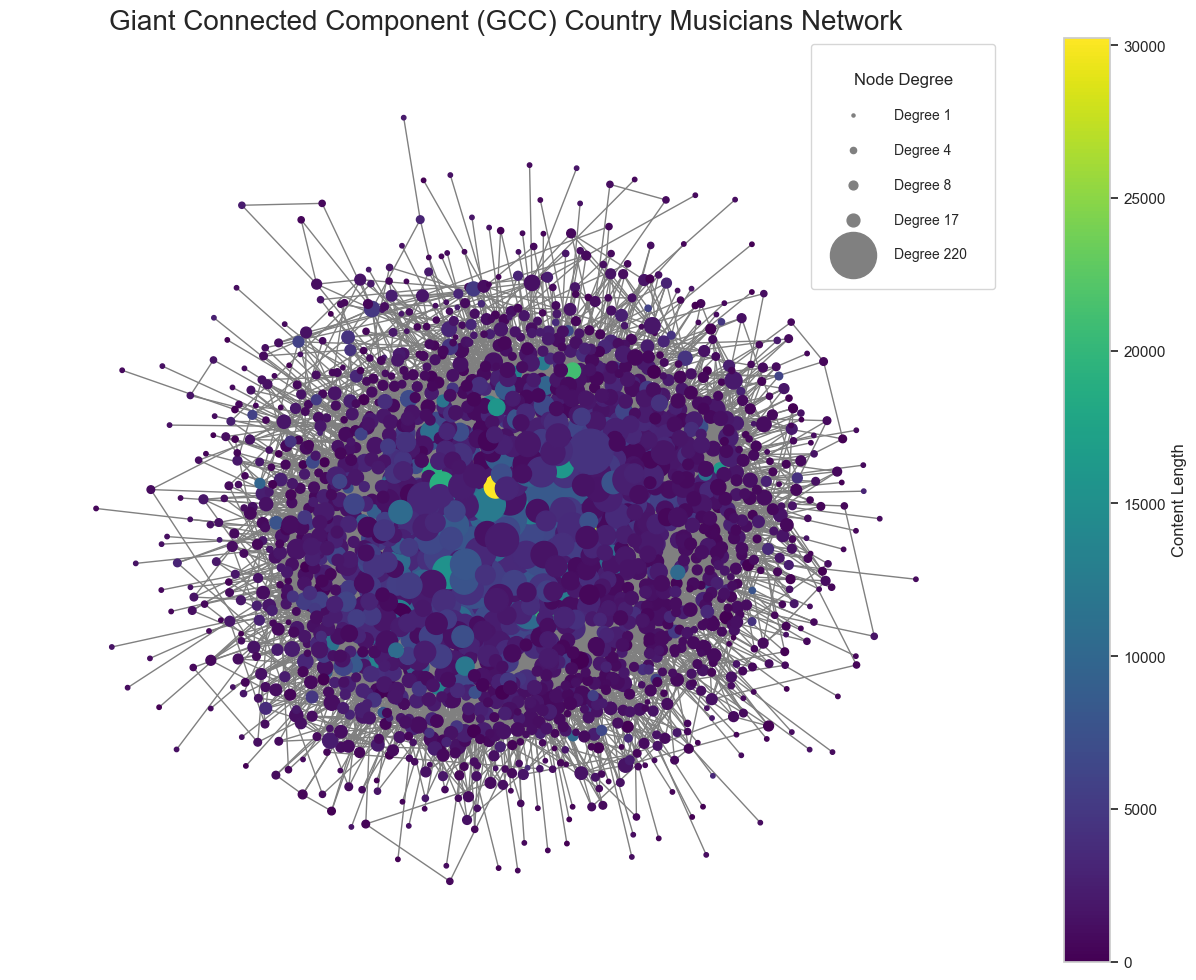

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import networkx as nx

# Get the Giant Connected Component (GCC)
gcc = max(nx.weakly_connected_components(G), key=len)

# Convert the GCC to an undirected graph
gcc_undirected = G.subgraph(gcc).to_undirected()

# Get the degree for each node in the GCC (used for node size)
degree_dict = dict(gcc_undirected.degree())

# Get the length_of_content attribute for each node (used for node color)
node_color_values = [data['length_of_content'] for node, data in gcc_undirected.nodes(data=True)]

# Normalize node size by degree (for better scaling in the plot)
node_size = [degree_dict[node] * 10 for node in gcc_undirected.nodes()]

# Define vmin and vmax for color normalization
vmin = min(node_color_values)
vmax = max(node_color_values)

# Plot using Kamada-Kawai layout
plt.figure(figsize=(16, 12))
pos = nx.kamada_kawai_layout(gcc_undirected)

# Draw edges
nx.draw_networkx_edges(gcc_undirected, pos, edge_color='gray')

# Draw nodes
nodes = nx.draw_networkx_nodes(
    gcc_undirected, 
    pos,
    node_size=node_size, 
    node_color=node_color_values, 
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

# Create colorbar using the nodes
cbar = plt.colorbar(nodes)
cbar.set_label('Content Length')

# Create legend for node sizes (degrees)
degrees = list(degree_dict.values())
quartiles = [min(degrees), 
             sorted(degrees)[len(degrees)//4],  # 1st quartile
             sorted(degrees)[len(degrees)//2],  # Median (2nd quartile)
             sorted(degrees)[(3*len(degrees))//4],  # 3rd quartile
             max(degrees)]

# Scale down the largest degree size for the legend
size_legend_handles = []
labels = []
for deg in quartiles:
    size = deg * 5
    handle = plt.scatter([], [], s=size, edgecolors='gray', facecolors='gray')
    size_legend_handles.append(handle)
    labels.append(f'Degree {deg}')

# Adjust the spacing and size of the legend box
plt.legend(size_legend_handles, labels,
           scatterpoints=1, loc='upper right', 
           title='Node Degree',
           labelspacing=1.5,      
           handletextpad=2.0,  
           borderpad=2.0,       
           fontsize=10,       
           frameon=True) 

# Set title
plt.title("Giant Connected Component (GCC) Country Musicians Network", fontsize=20)

# Show plot
plt.axis('off')
plt.show()


The visualization of the Giant Connected Component (GCC) of the country musicians network shows a dense, interconnected core, where node size corresponds to the degree (number of connections) and color represents the length of each musician's Wikipedia content. Larger, more central nodes, like Willie Nelson and Johnny Cash, are highlighted by their high degree and significant content length, while peripheral nodes are smaller and less connected, indicating less centrality in the network. The gradient color scale provides an additional layer of insight into the depth of information available for each musician.